# Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
import pickle
import tensorflow as tf
import seaborn as sns
import scipy as sp

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, TimeSeriesSplit, train_test_split
from sklearn.ensemble import RandomForestRegressor

from tqdm import tqdm

In [2]:
from utils.model_summary_functions import feature_importance, metrics, summary_plot,multivariate_importance
from utils.plotting import plot_autocorrelation

In [3]:
import warnings # Serve para ignorar mensagens de alerta que aparecem 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
plt.style.use('default')

plt.rcParams.update({
    'font.size': 16,
    'axes.linewidth': 2,
    'axes.titlesize': 20,
    'axes.edgecolor': 'black',
    'axes.labelsize': 20,
    'axes.grid': True,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'figure.figsize': (15, 6),
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'font.family': 'Arial',
    'legend.fontsize': 13,
    'legend.framealpha': 1,
    'legend.edgecolor': 'black',
    'legend.shadow': False,
    'legend.fancybox': True,
    'legend.frameon': True,
    'text.color':'black',
    'axes.labelcolor': 'black',
})


In [5]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Importing Kuramoto dataset

We first import the solution obtained from the Kuramoto differential equation subject to periodic boundary conditions. The spatial domain has length L=200 and discretized with 512 nodes. The time step was 0.25 seconds with a time domain from t=0 to t=2000 seconds. 

$$ u_t + u_x u + u_{xx} + u_{xxxx}=0 \tag{1}$$ 


$$ u(t=0,x) = cos \frac{\pi x}{20}*(1+sin\frac{\pi x}{20})  \tag{2}$$


The first 500 seconds were truncated in order to avoid transients and model only the chaotic part of the solution

In [6]:
#X = np.load('Kuramoto_dataset\Kuramoto_X.npy')
#T = np.load('Kuramoto_dataset\Kuramoto_T.npy')
#U = np.load('Kuramoto_dataset\Kuramoto_U.npy')

X = np.linspace(0,200,512) # Discrete space domain vector
T = np.load('Kuramoto_dataset\KSTime.npy') # Discrete time domain vector
U = np.load('Kuramoto_dataset\KSSolution.npy') # Solution
X, T = np.meshgrid(X, T)

# Converting time to Lyapunov time

MLE = 0.094 # Maximal Lyapunov Time
T_lyapunov = T*MLE

print(X.shape)
print(T.shape)
print(U.shape)

(6000, 512)
(6000, 512)
(6000, 512)


In [7]:
#np.savetxt('data.csv', U, delimiter=',')

In [8]:
# fig, ax = plt.subplots(figsize=(14, 7))

# surf = ax.pcolor(X, T_lyapunov, U, cmap=plt.get_cmap("seismic"),shading='auto')

# plt.colorbar(surf)
# plt.xlabel('X')
# plt.ylabel('T $\Lambda_{max}$')
# plt.tight_layout()

## Creating the training and test set for evaluating PCA

The dataset has columns rows and 6000 rows. The first 90% will be used for training and the remaining 10% for testing. The time series sequence must be respected, so we cannot shuffle the data.

In [9]:
X_train = X[:5400]
T_train = T[:5400]
U_train = U[:5400]
X_test = X[5400:]
T_test = T[5400:]
U_test = U[5400:]

# X_train = X[:28000]
# T_train = T[:28000]
# U_train = U[:28000]

# X_test = X[28000:]
# T_test = T[28000:]
# U_test = U[28000:]

In [10]:
print(U_train.shape)
print(U_test.shape)
print('')
print(X_train.shape)
print(X_test.shape)
print('')
print(T_train.shape)
print(T_test.shape)

(5400, 512)
(600, 512)

(5400, 512)
(600, 512)

(5400, 512)
(600, 512)


In [11]:
# Normalizing the dataset to be with 0 mean and unit variance
scaler = StandardScaler()

U_scaled_train = scaler.fit_transform(U_train)
U_scaled_test = scaler.transform(U_test)

# Applying dimensionality reduction for the Kuramoto dataset - PCA

In [12]:
from utils import dim_reduction

## Threshold based on energy criteria

PCA model: PCA(n_components=92)


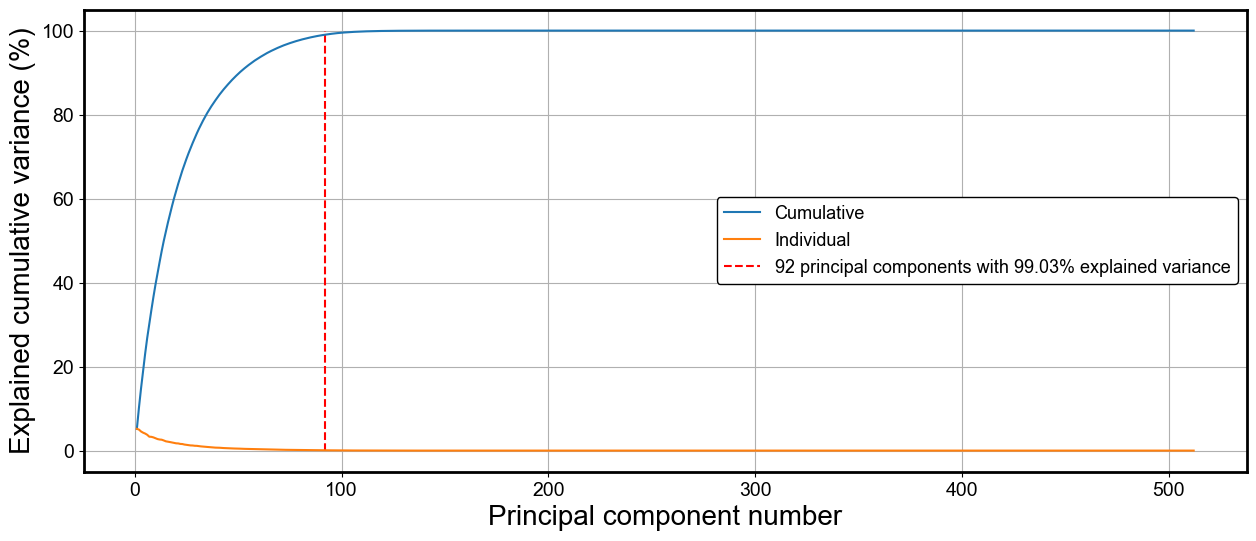

In [13]:
threshold = 0.99 # Maintain 99% of variance in the dataset
pca = dim_reduction.pca(U=U_scaled_train,threshold=threshold)
#path = './pca_models/pca_Kuramoto'
#pca.save_model(path=path)

print('PCA model:', pca.model_red)
pca.plot_pca()

In [14]:
# Reduce dimensionality of the data
U_train_pca = pca.model_red.fit_transform(U_scaled_train)
U_test_pca = pca.model_red.transform(U_scaled_test)

print(U_scaled_train.shape)
print(U_train_pca.shape)

(5400, 512)
(5400, 92)


In [15]:
U_train_reduced = pca.model_red.inverse_transform(U_train_pca)
U_test_reduced = pca.model_red.inverse_transform(U_test_pca)

print(U_scaled_train.shape)
print(U_train_reduced.shape) # Return to the original domain after cutting eigenvectors

# Apply inverse standard scaler transform to obtain dataset in same scale as the original data
U_train_reduced_inverse = scaler.inverse_transform(U_train_reduced)  
U_test_reduced_inverse = scaler.inverse_transform(U_test_reduced)

(5400, 512)
(5400, 512)


In [16]:
# fig, ax, diff = pca.plot_compare(X=X_train,
#                  T=T_train,
#                  U = U_train,
#                  U_reduced = U_train_reduced_inverse)

# print('Mean absolute error (MAE) for training set: {}'.format(diff.mean()))

In [17]:
# fig, ax, diff = pca.plot_compare(X=X_test,
#                  T=T_test,
#                  U = U_test,
#                  U_reduced = U_test_reduced_inverse)

# print('Mean absolute error (MAE) for test set: {}'.format(diff.mean()))

## Final ROM 

In [18]:
scaler2 = StandardScaler()
U_scaled2 = scaler2.fit_transform(U)

# Initializing PCA class
pca = dim_reduction.pca(U=U_scaled2,threshold=threshold)
U_pca = pca.model_red.fit_transform(U_scaled2)
U_pca.shape

(6000, 93)

In [19]:
path = './pca_models/pca_Kuramoto'
pickle.dump(pca, open(path, 'wb'))
path = './pca_models/standardscaler'
pickle.dump(scaler2, open(path, 'wb'))

In [20]:
df = pd.DataFrame(U_pca)
df

,0,1,2,3,4,5,6,7,8,9,...,83,84,85,86,87,88,89,90,91,92
0,5.472871,1.217982,6.230086,-0.950462,0.863161,-1.352218,4.725135,-4.429206,1.363932,-2.402084,...,0.042324,-0.628976,0.303736,1.050924,-0.319772,0.452098,-0.454401,-0.395371,-0.434333,-0.886681
1,5.456736,1.030217,6.275587,-0.838791,0.975329,-1.566040,4.830630,-4.338888,1.385022,-2.258257,...,0.149707,-0.568629,0.224101,0.962598,-0.370399,0.411446,-0.487105,-0.412622,-0.438104,-0.947290
2,5.456897,0.833749,6.308572,-0.730643,1.086719,-1.799117,4.927997,-4.225563,1.400620,-2.127380,...,0.244525,-0.515302,0.145613,0.862979,-0.416856,0.365906,-0.515017,-0.417493,-0.444786,-1.012555
3,5.472629,0.629589,6.327787,-0.628478,1.196396,-2.050700,5.015677,-4.089995,1.407393,-2.009958,...,0.322812,-0.469722,0.069574,0.750927,-0.458162,0.317323,-0.536380,-0.407113,-0.455174,-1.079685
4,5.501610,0.419481,6.331751,-0.534753,1.303558,-2.319721,5.092144,-3.933463,1.401821,-1.906113,...,0.380772,-0.431966,-0.002469,0.625161,-0.493436,0.267659,-0.549715,-0.378990,-0.469812,-1.145273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,-4.149586,1.311779,-1.733645,2.995828,-9.173312,2.279188,-0.460554,2.574104,1.066336,-3.507364,...,-0.038440,-0.516034,-0.068059,-1.804518,0.456283,0.363398,0.108329,-0.124854,-0.227933,0.457089
5996,-3.869611,1.194403,-1.635748,3.000731,-9.144402,2.275107,-0.266543,2.343572,1.135160,-3.420423,...,-0.124407,-0.503931,-0.087439,-1.899951,0.439299,0.353236,0.017841,-0.117174,-0.337113,0.505647
5997,-3.593313,1.100201,-1.565852,3.003578,-9.102322,2.267642,-0.078799,2.113092,1.207276,-3.346010,...,-0.207155,-0.505051,-0.082344,-1.931616,0.433744,0.329172,-0.068791,-0.108082,-0.390954,0.545995
5998,-3.312633,1.021631,-1.519267,3.001866,-9.045092,2.256996,0.095221,1.893864,1.292517,-3.293154,...,-0.283526,-0.518721,-0.052140,-1.902229,0.440545,0.296793,-0.149900,-0.107087,-0.395280,0.572288


In [21]:
df.to_csv('Processed_datasets/reduced_dataset.csv.zip', index=False, compression="zip")